# Определение перспективного тарифа для телеком компании

***Описание проекта***
Я аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Мне предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В моем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше

### Описание тарифов
- ***Тариф «Смарт»***
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей
- 
- ***Тариф «Ультра»***
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей



## Шаг 1. Открыть файл с данными и изучить общую информацию

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
from scipy import stats as st
import numpy as np

In [2]:
calls = pd.read_csv("/datasets/calls.csv")
internet = pd.read_csv("/datasets/internet.csv")
messages = pd.read_csv("/datasets/messages.csv")
tariffs = pd.read_csv("/datasets/tariffs.csv")
users = pd.read_csv("/datasets/users.csv")
calls.info()
internet.info()
messages.info()
tariffs.info()
users.info()
display(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
<class 'pandas.core.frame.DataFrame'>
Rang

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


## Шаг 2. Подготовка данных

***Замена типа данных***

In [3]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format= '%Y-%m-%d') # Замена типа значения на datetime64

del internet['Unnamed: 0']
internet['session_date'] = pd.to_datetime(internet['session_date'], format= '%Y-%m-%d') # Замена типа значения на datetime64

messages['message_date'] = pd.to_datetime(messages['message_date'], format= '%Y-%m-%d') # Замена типа значения на datetime64

users['churn_date'] = pd.to_datetime(users['churn_date'], format= '%Y-%m-%d') # Замена типа значения на datetime64
users['reg_date'] = pd.to_datetime(users['reg_date'], format= '%Y-%m-%d') # Замена типа значения на datetime64


***Исправление ошибок в Дата сете***

0.0    39613
Name: duration, dtype: int64


Text(0.5, 1.0, 'Зависимость нулевых звонков от общего количства ')

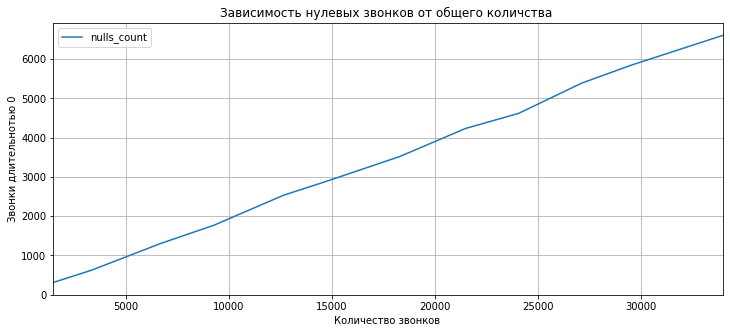

In [4]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month # добавим столбец со значением месяца
# Количество звонков с длительностью, равной нулю
ziro = calls.loc[calls['duration'] == 0]
print(ziro['duration'].value_counts())

# График зависемости количества звонков и нуливых значений 
calls.loc[calls['duration'] == 0, 'nulls_count'] = 1
null_calls = calls.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')

null_calls.pivot_table(index='id', values='nulls_count').plot(grid=True, figsize=(12, 5))
plt.xlabel('Количество звонков ')
plt.ylabel('Звонки длительнотью 0')
plt.title('Зависимость нулевых звонков от общего количства ')


Появление нулевых звонков сичтематично. Все значения округляем в большую сторону.

In [5]:
calls.loc[(calls['duration'] == 0)] = 1

0.0    19598
Name: mb_used, dtype: int64


Text(0.5, 1.0, 'Зависимость нулевых значений от общего количства ')

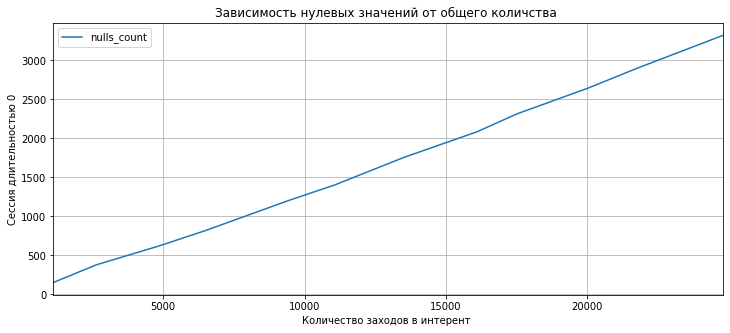

In [6]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month # добавим столбец со значением месяца
# Количество трафика с длительностью, равной нулю
ziro = internet.loc[internet['mb_used'] == 0]
print(ziro['mb_used'].value_counts())

# График зависемости количества трафика и нуливых значений 
internet.loc[internet['mb_used'] == 0, 'nulls_count'] = 1
null_internet = internet.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')

null_internet.pivot_table(index='id', values='nulls_count').plot(grid=True, figsize=(12, 5))
plt.xlabel('Количество заходов в интерент ')
plt.ylabel('Сессия длительностью 0')
plt.title('Зависимость нулевых значений от общего количства ')

In [7]:
# Все так-же как с звонками
internet.loc[(internet['mb_used'] == 0)] = 1

***Значения для каждого пользователя***

In [8]:
# Сводая таблица звонков
calls_users = calls.merge(users, on='user_id', how='inner')

calls_group = calls_users.pivot_table(values=['first_name', 'duration'], index=['user_id', 'month'], 
                       aggfunc={'first_name': 'count', 'duration': 'sum'})
calls_group.columns = ['duration', 'calls']


# Сводая таблица сообщений
messages['month'] = pd.DatetimeIndex(messages['message_date']).month # добавим столбец со значением месяца
messages_users = messages.merge(users, on='user_id', how='inner')

messages_group = messages_users.pivot_table(values='first_name', index=['user_id', 'month'], 
                       aggfunc={'first_name': 'count'})
messages_group.columns = ['messages']


# сводная таблица интернет
internet_users = internet.merge(users, on='user_id', how='inner')

internet_group = internet_users.pivot_table(values=['first_name', 'mb_used'], index=['user_id', 'month'], 
                       aggfunc={'first_name': 'count', 'mb_used': 'sum'})
internet_group.columns = ['mb_used', 'internet']


In [9]:
final_data = internet_group.merge(calls_group,on=['user_id', 'month'], how='outer')
final_data = final_data.merge(messages_group,on=['user_id', 'month'], how='outer')
final_data

mb_used  internet  duration  calls  messages
user_id month                                              
1000    5          4.0   2253.49    150.06   17.0      22.0
        6         44.0  23233.77    158.90   28.0      60.0
        7         28.0  14003.64    318.80   41.0      75.0
        8         27.0  14055.93    389.87   42.0      81.0
        9         25.0  14568.91    440.14   46.0      57.0
...                ...       ...       ...    ...       ...
1273    12         NaN       NaN    241.59   38.0      39.0
1365    10         NaN       NaN     40.85    5.0       1.0
1377    2          NaN       NaN    168.55   20.0       2.0
1392    2          NaN       NaN     11.96    2.0       3.0
1446    8          NaN       NaN     46.98    4.0       1.0

[3214 rows x 5 columns]

In [10]:
print(f'Количество клиентов: {final_data.reset_index().user_id.nunique()}')

Количество клиентов: 498


In [11]:
# замена прощеных значенй на нули
final_data.loc[final_data['duration'].isna(), 'duration'] = 0
final_data.loc[final_data['messages'].isna(), 'messages'] = 0
final_data.loc[final_data['mb_used'].isna(), 'mb_used'] = 0

# Добавление тарифа
for user in final_data.index:
    final_data.loc[user, 'tariff'] = users.loc[user[0]-1000, 'tariff']
display(final_data)

mb_used  internet  duration  calls  messages tariff
user_id month                                                     
1000    5          4.0   2253.49    150.06   17.0      22.0  ultra
        6         44.0  23233.77    158.90   28.0      60.0  ultra
        7         28.0  14003.64    318.80   41.0      75.0  ultra
        8         27.0  14055.93    389.87   42.0      81.0  ultra
        9         25.0  14568.91    440.14   46.0      57.0  ultra
...                ...       ...       ...    ...       ...    ...
1273    12         0.0       NaN    241.59   38.0      39.0  ultra
1365    10         0.0       NaN     40.85    5.0       1.0  smart
1377    2          0.0       NaN    168.55   20.0       2.0  ultra
1392    2          0.0       NaN     11.96    2.0       3.0  ultra
1446    8          0.0       NaN     46.98    4.0       1.0  smart

[3214 rows x 6 columns]

In [12]:
'''

Функция возвращает сколько компаня имеет с каждого пользователя по значениям 

messages, mb_used, tariff, duration используя правила:

Вычтем бесплатный лимит из всех, сообщений и интернет-трафика и звонков.

остаток свыше лимита умножим на значения из тарифного плана.

После прибавим абонентскую плату.

'''
def user_pay(row):
    messages = row['messages']
    mb_used = row['mb_used']
    tariff = row['tariff']
    duration = row['duration']
    
    if tariff == 'smart':
        extra_duration = duration - tariffs.loc[0, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[0, 'mb_per_month_included']
        extra_messages = messages - tariffs.loc[0, 'messages_included']
        
        if extra_duration < 0:
            extra_duration = 0
        if extra_mb < 0:
            extra_mb = 0
        if extra_messages < 0:
            extra_messages = 0
        
        mes1 = tariffs.loc[0, 'rub_per_message'] * extra_messages
        traf1 = (tariffs.loc[0, 'rub_per_gb'] / 1024) * extra_mb
        min1 = tariffs.loc[0, 'rub_per_minute'] * extra_duration
        
        return mes1 + traf1 + min1 + tariffs.loc[0, 'rub_monthly_fee']
                  
    else:
        extra_duration = duration - tariffs.loc[1, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[1, 'mb_per_month_included']
        extra_messages = messages - tariffs.loc[1, 'messages_included']
                
        if extra_duration < 0:
            extra_duration = 0
        if extra_mb < 0:
            extra_mb = 0
        if extra_messages < 0:
            extra_messages = 0
        
        mes2 = tariffs.loc[1, 'rub_per_message'] * extra_messages
        traf2 = (tariffs.loc[1, 'rub_per_gb'] / 1024) * extra_mb
        min2 = tariffs.loc[1, 'rub_per_minute'] * extra_duration
        
        return mes2 + traf2 + min2 + tariffs.loc[1, 'rub_monthly_fee']
                  

final_data['user_pays'] = final_data.apply(user_pay, axis=1)

## Шаг 3. Анализ данных

In [13]:
# Сколько в среднем нужно каждому пользователю сообщенй, интернета и звонков 
median_found = final_data.pivot_table(index='user_id', values=['duration', 'messages', 'mb_used', 'user_pays'], aggfunc='median')
for user_id in users['user_id']:
    median_found.loc[user_id, 'tariff'] = users.loc[user_id-1000, 'tariff']
median_found.head()


,duration,mb_used,messages,user_pays,tariff
user_id,,,,,
1000,318.920,26.0,65.0,1950.0,ultra
1001,399.730,41.0,0.0,550.0,smart
1002,204.750,44.0,11.0,550.0,smart
1003,775.390,21.0,83.0,1950.0,ultra
1004,123.935,33.0,154.5,1950.0,ultra


In [14]:
median_found.dropna(subset=['duration'], inplace=True)
ultra = median_found[median_found['tariff'] == 'ultra']
smart = median_found[median_found['tariff'] == 'smart']
print(ultra.median()) # медиана
print(np.var(ultra)) # дисперсия по выборке
print(np.std(ultra)) # стандартное отклонение по выборке
print(smart.median()) # медиана
print(np.var(smart)) # дисперсия по выборке
print(np.std(smart)) # стандартное отклонение по выборке

duration      506.9225
mb_used        37.0000
messages       47.5000
user_pays    1950.0000
dtype: float64
duration     81554.883453
mb_used        281.901844
messages      2407.883161
user_pays        0.000000
dtype: float64
duration     285.578156
mb_used       16.789933
messages      49.070186
user_pays      0.000000
dtype: float64
duration     415.39
mb_used       44.00
messages      28.50
user_pays    550.00
dtype: float64
duration     22883.670708
mb_used        113.133553
messages       782.354957
user_pays    38968.244981
dtype: float64
duration     151.273496
mb_used       10.636426
messages      27.970609
user_pays    197.403761
dtype: float64


По всем пораметрам тариф Ультра обгоняет своего конкурента. Медиана смещена в большую сторону. Так же он имеет большую дисперсию. 

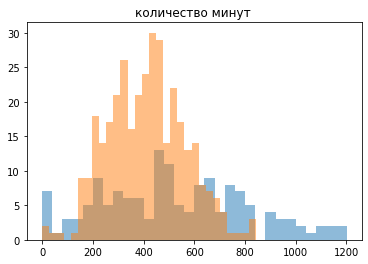

In [15]:
plt.title('количество минут ')
x = ultra['duration']  
y = smart['duration']

plt.hist(x, bins = 30, alpha=0.5, label='ultra')
plt.hist(y, bins = 30, alpha=0.5, label='smart')
plt.show()

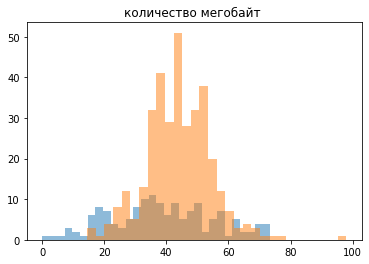

In [16]:
plt.title('количество мегобайт ')
x = ultra['mb_used']  
y = smart['mb_used']

plt.hist(x, bins = 30, alpha=0.5, label='ultra')
plt.hist(y, bins = 30, alpha=0.5, label='smart')
plt.show()

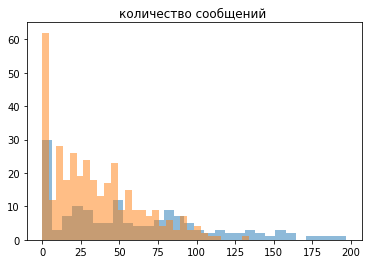

In [17]:
plt.title('количество сообщений ')
x = ultra['messages']  
y = smart['messages']

plt.hist(x, bins = 30, alpha=0.5, label='ultra')
plt.hist(y, bins = 30, alpha=0.5, label='smart')
plt.show()

Более дешовый тариф имеет больше выбросов. Мне кажется люди покупая дешовый тариф пытаются не выходить за рамки пакета, а в дорогом им без разницы. потому что очень сложно потратить весь пакет.

## Шаг 4. Проверка гипотез

***Мы проверяем гипотезу о равенстве средних двух независимых совокупностей среднее колличество потраченных денег в 2х тарифах ultra и smart***
- H1 = колличество потраченных денег в 2х тарифах ultra и smart равна
- H0 = колличество потраченных денег в 2х тарифах ultra и smart различны

In [18]:
ult = ultra['user_pays']
smt = smart['user_pays']


alpha = .05

results = st.ttest_ind( 
   ult, 
    smt)  

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.777676548056522e-284
Отвергаем нулевую гипотезу


In [19]:
print(ult.median())
print(smt.median(),'\n')
print(np.var(ult)) # дисперсия по выборке
print(np.var(smt),'\n') # дисперсия по выборке
print(np.std(ult)) # стандартное отклонение по выборке
print(np.std(smt)) # стандартное отклонение по выборке

1950.0
550.0 

0.0
38968.24498108347 

0.0
197.40376131442753


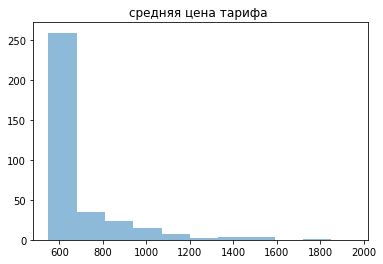

In [20]:
plt.title('средняя цена тарифа ')
x = ult  
y = smt

plt.hist(y, alpha=0.5, label='ultra')
plt.hist(x, alpha=0.5, label='smart')
plt.show()

Среднее значение отличавется почти в 4 раза. Однозначно можно сказать, что тариф ульра более выгоден компании.

***Мы проверяем гипотезу о равенстве средних двух независимых совокупностей среднее колличество потраченных денег пользователями Москвы и остальных городов***
- H0 = среднее колличество потраченных денег пользователями Москвы и остальных городов равно 
- H1 = среднее колличество потраченных денег пользователями Москвы и остальных городов отличается

In [21]:
for user in final_data.index:
    final_data.loc[user, 'city'] = users.loc[user[0]-1000, 'city']
    
moscow = final_data.query('city == "Москва"')['user_pays']
other = final_data.query('city != "Москва"')['user_pays']

alpha = .05

results = st.ttest_ind(
    moscow, 
    other)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.001319292563351182
Отвергаем нулевую гипотезу


In [22]:
print(moscow.median())
print(other.median(),'\n')
print(np.var(moscow)) # дисперсия по выборке
print(np.var(other),'\n') # дисперсия по выборке
print(np.std(moscow)) # стандартное отклонение по выборке
print(np.std(other)) # стандартное отклонение по выборке

697.0
634.0 

418076.5091932095
379398.21494777396 

646.5883614736732
615.9530947627213


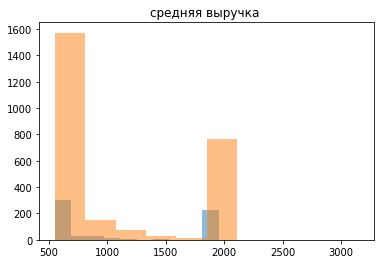

In [23]:
plt.title('средняя выручка ')
x = moscow  
y = other

plt.hist(x, alpha=0.5, label='moscow')
plt.hist(y, alpha=0.5, label='other')
plt.show()

Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Так как мы отвергаем нулевую гипотезу. 
Мне кажется различие не такое большое.
В обоих случаях я  спользовал гипотезу о равенстве средних двух генеральных совокупностей

## Шаг 5. Общий вывод

Тариф ультра приносит больше чем смарт примерно в 4 раза 1950 против 556 рублей.
В Москве люди тратят на связь примерно столько же сколько и в регионах. 
Пользователи тарифа ультра не успевают использовать весь пакет, а вот абоненты пользующиеся тарифом смарт наоборот почти все покупают доп услуги. 




***Ребятам из отдела маркетинга можно порекомендовать продвигать тариф ультра)***